# CT Images Denoising - Synthetic Images

Description of the jupyter notebook and maybe brief overview of the all project.

**Authors:** [Raphaël Achddou](https://people.epfl.ch/raphael.achddou) ([contact](mailto:raphael.achddou@epfl.ch)), [Paulo Ribeiro](https://people.epfl.ch/paulo.ribeirodecarvalho) ([contact](mailto:paulo.ribeirodecarvalho@epfl.ch))

## Import
Let's first import all libraries needed for the production of synthetic images using dead leaves.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import cv2

from helpers import *
from skimage import exposure

%load_ext autoreload
%autoreload 2

## Load Data

To create meaningful synthetic images, we made them statistically equivalent to real images. Then, samples of real CT images are needed.

In [2]:
#TODO: Still need to download all the images. Only downloaded a small batch (8Go of 150Go)
path_training = 'data/train/L506'
path_qd = '/DICOM-CT-PD_QD/'
path_fd = '/DICOM-CT-PD_FD/'

#l506_qd = load_data(''.join([path_training, path_qd]))
l506_fd = load_data(''.join([path_training, path_fd]))

We can now have a look at each patient and each projection of the training images.

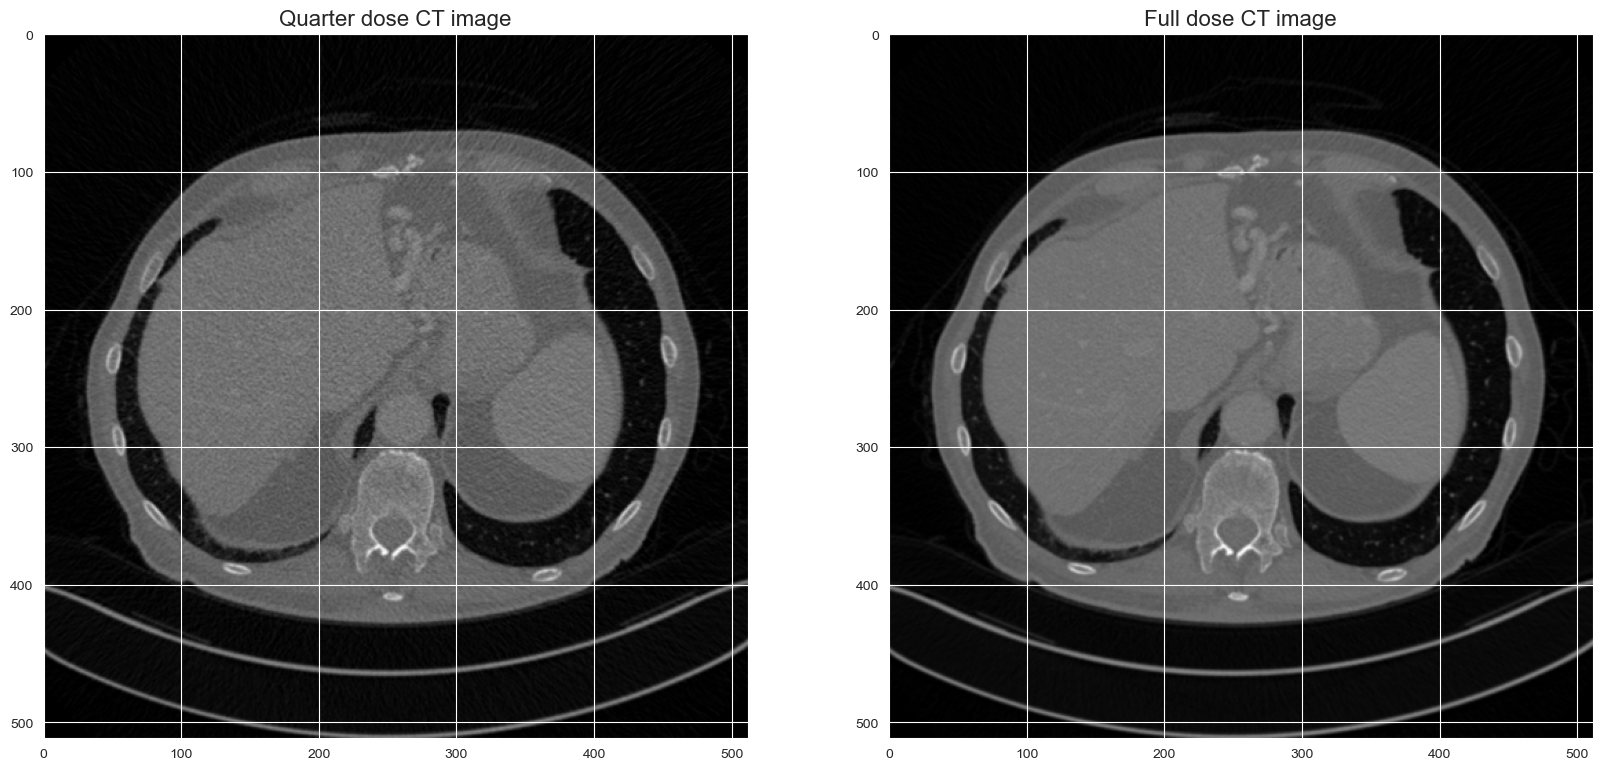

In [3]:
# Enhance the contrast of images ! But careful because might be performing a image processing step.
# exp_img = exposure.equalize_adapthist(pixel_img)

idx = 45  # select one of the 600 projection of patient L506

fig, axs = plt.subplots(1, 2, figsize=(10,10))

#axs[0].imshow(l506_qd[idx], cmap="binary")
axs[1].imshow(l506_fd[idx], cmap="binary")

plt.show()

## Statistical Analysis

As mention above, a statistical analysis from the real CT images need to be done to replicate the statistics in our synthetic images. We will focus on these following stat metrics :

1) color distribution
2) sharpness of the images
3) ...

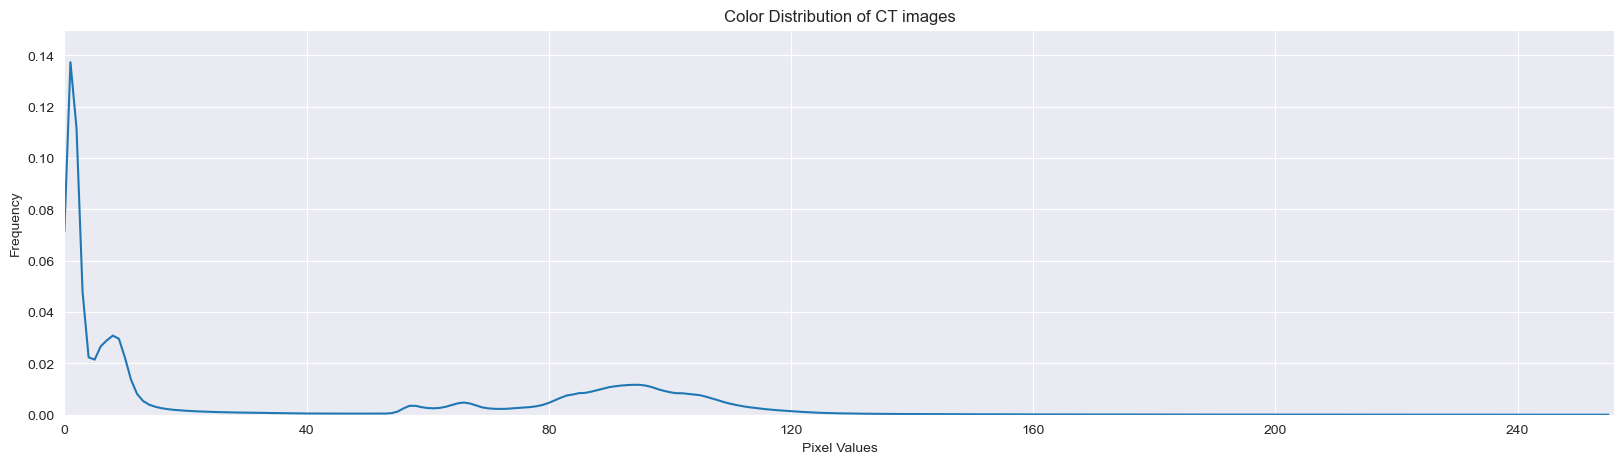

In [4]:
#TODO: Talk with Raphaël about which other metrics can be added
pixel_values, color_dist = color_distribution(l506_qd, plot=True)

## Synthetic Images Generation

Now, let's compute our synthetic images using our knowledge from the real CT images.

In [ ]:
pass  #TODO: Talk about how many

## Noise Statistical Analysis

Use the full and quarter dose projection, respectively FD and QD, to empirically compute the noise distribution. This way, we will be able to add some noise on our synthetic images to be able to train our model later on.

In [ ]:
#TODO: Compute the noise distribution observed on our sample of CT real images